Section 1(Normalization)

In [ ]:
# Min-Max Normalization for Hyperspectral Data

import pandas as pd                       # For reading/writing Excel/CSV and handling DataFrames
from sklearn.preprocessing import MinMaxScaler   # For Min-Max scaling of features

#  Load the dataset 
input_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/hyperspectral.xlsx"  # Path to Excel file
df = pd.read_excel(input_path)            # Read the Excel file into a DataFrame

print("Original Columns:", df.columns.tolist())   # Show all column names for verification
print("Shape before:", df.shape)                  # Print dataset shape (rows, columns) before preprocessing

#  Drop unwanted columns 
drop_cols = ['Image ID', 'Minimum Reflectance', 'Otsu Threshold']  # Columns to remove
df = df.drop(columns=drop_cols, errors='ignore')  # Drop them; ignore errors if any column not present

#  Separate target column 
target_col = 'Yield'                      # This is the target variable
y = df[target_col]                         # Store Yield separately (we don’t normalize it)
X = df.drop(columns=[target_col])          # All other columns are features to normalize

#  Min-Max normalization 
scaler = MinMaxScaler()                    # Create MinMaxScaler instance (default range: 0–1)
X_scaled = scaler.fit_transform(X)         # Fit scaler to features & transform them into scaled array

#  Reconstruct DataFrame 
normalized_df = pd.DataFrame(X_scaled, columns=X.columns)  # Convert scaled array back to DataFrame with original column names
normalized_df[target_col] = y                               # Add back the original Yield column (unscaled)

print("Shape after normalization:", normalized_df.shape)    # Print new shape after dropping columns and adding scaled features

#  Save processed file 
output_path = "normalized_minmax_with_target.csv"           # Output file name (will save in current working directory)
normalized_df.to_csv(output_path, index=False)              # Save normalized data to CSV without row index

print(f"✅ Normalized file saved as: {output_path}")         # Confirmation message after saving


Original columns: ['Image ID', '400 nm', '402 nm', '405 nm', '408 nm', '411 nm', '414 nm', '417 nm', '420 nm', '423 nm', '426 nm', '429 nm', '432 nm', '435 nm', '438 nm', '441 nm', '444 nm', '447 nm', '450 nm', '453 nm', '456 nm', '459 nm', '462 nm', '465 nm', '467 nm', '470 nm', '473 nm', '476 nm', '479 nm', '482 nm', '485 nm', '488 nm', '491 nm', '494 nm', '497 nm', '500 nm', '503 nm', '506 nm', '509 nm', '512 nm', '515 nm', '518 nm', '521 nm', '524 nm', '527 nm', '530 nm', '533 nm', '535 nm', '538 nm', '541 nm', '544 nm', '547 nm', '550 nm', '553 nm', '556 nm', '559 nm', '562 nm', '565 nm', '568 nm', '571 nm', '574 nm', '577 nm', '580 nm', '583 nm', '586 nm', '589 nm', '592 nm', '595 nm', '598 nm', '600 nm', '603 nm', '606 nm', '609 nm', '612 nm', '615 nm', '618 nm', '621 nm', '624 nm', '627 nm', '630 nm', '633 nm', '636 nm', '639 nm', '642 nm', '645 nm', '648 nm', '651 nm', '654 nm', '657 nm', '660 nm', '663 nm', '666 nm', '668 nm', '671 nm', '674 nm', '677 nm', '680 nm', '683 nm',

Section 2(KS)

In [3]:
# Data partition using KS(Kennard–Stone) method
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load dataset
input_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/normalized_minmax_with_target.csv"
df = pd.read_csv(input_path)

# Identify columns
keep_cols = ['Image ID', 'Yield', 'Minimum Reflectance', 'Otsu']  # Columns not for splitting
keep_cols_existing = [col for col in keep_cols if col in df.columns]  # Keep only existing ones
X_cols = [col for col in df.columns if col not in keep_cols_existing]  # Band columns only
X = df[X_cols].values  # Extract values for splitting

# Define Kennard–Stone algorithm
def kennard_stone(X, n_samples):
    n_total = X.shape[0]
    dist_matrix = cdist(X, X, metric='euclidean')  # Pairwise Euclidean distance
    
    # Step 1: select two farthest samples
    i1, i2 = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)
    selected = [i1, i2]
    remaining = list(set(range(n_total)) - set(selected))
    
    # Step 2: iteratively select farthest points from selected set
    while len(selected) < n_samples:
        dist_to_selected = np.min(dist_matrix[remaining][:, selected], axis=1)
        next_idx = remaining[np.argmax(dist_to_selected)]
        selected.append(next_idx)
        remaining.remove(next_idx)
    
    return selected

# Split dataset
n_train = int(0.8 * X.shape[0])  # 80% for training
train_idx = kennard_stone(X, n_train)
test_idx = list(set(range(X.shape[0])) - set(train_idx))

df_train = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

# Save output CSV files
df_train.to_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks.csv", index=False)
df_test.to_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks.csv", index=False)

print("✅ Kennard–Stone split done!")
print("Train set shape:", df_train.shape)
print("Test set shape :", df_test.shape)


✅ Kennard–Stone split done!
Train set shape: (1928, 205)
Test set shape : (482, 205)


In [4]:
# Data partition using SPXY (Sample set Partitioning based on joint X–Y distances)
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load dataset
input_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/normalized_minmax_with_target.csv"
df = pd.read_csv(input_path)

# Identify columns
keep_cols = ['Image ID', 'Yield', 'Minimum Reflectance', 'Otsu']  # Columns not for splitting
keep_cols_existing = [col for col in keep_cols if col in df.columns]
X_cols = [col for col in df.columns if col not in keep_cols_existing]  # Band columns only

X = df[X_cols].values
y = df[['Yield']].values  # include target for SPXY

# ----- SPXY Algorithm -----
def spxy(X, y, n_samples):
    # Normalize X and y to avoid scale domination
    X_norm = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    y_norm = (y - y.mean(axis=0)) / (y.std(axis=0) + 1e-8)

    # Concatenate features + target
    Z = np.hstack((X_norm, y_norm))

    n_total = Z.shape[0]
    dist_matrix = cdist(Z, Z, metric='euclidean')

    # Step 1: select two farthest samples
    i1, i2 = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)
    selected = [i1, i2]
    remaining = list(set(range(n_total)) - set(selected))

    # Step 2: iteratively select farthest samples
    while len(selected) < n_samples:
        dist_to_selected = np.min(dist_matrix[remaining][:, selected], axis=1)
        next_idx = remaining[np.argmax(dist_to_selected)]
        selected.append(next_idx)
        remaining.remove(next_idx)

    return selected

# ----- Split dataset -----
n_train = int(0.8 * X.shape[0])  # 80% for training
train_idx = spxy(X, y, n_train)
test_idx = list(set(range(X.shape[0])) - set(train_idx))

df_train = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

# Save output CSV files
df_train.to_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_spxy.csv", index=False)
df_test.to_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_spxy.csv", index=False)

print("✅ SPXY split done!")
print("Train set shape:", df_train.shape)
print("Test set shape :", df_test.shape)


KeyboardInterrupt: 

Section 3(PLSR)

In [6]:
# Train using PLSR (Partial Least Squares Regression) technique
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
from sklearn.cross_decomposition import PLSRegression  # PLS regression model
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics

# Load train and test datasets
train_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks.csv")  # Load training CSV
test_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks.csv")  # Load testing CSV

print("Train shape:", train_df.shape)  # Show training data shape
print("Test shape:", test_df.shape)  # Show testing data shape

# Separate features (X) and target (y)
target_column = "Yield"  # Replace with your actual target column name
X_train = train_df.drop(columns=[target_column])  # Features for training
y_train = train_df[target_column]  # Target for training

X_test = test_df.drop(columns=[target_column])  # Features for testing
y_test = test_df[target_column]  # Target for testing

# Standardize the feature data
scaler = StandardScaler()  # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training features
X_test_scaled = scaler.transform(X_test)  # Transform testing features with same scaler

# Train PLSR model with up to 10 components
n_components = min(X_train.shape[1], 10)  # Choose number of components (max 10 or number of features)
pls = PLSRegression(n_components=n_components)  # Initialize PLS model
pls.fit(X_train_scaled, y_train)  # Fit PLS model to training data

# Make predictions
y_pred_train = pls.predict(X_train_scaled)  # Predict on training set
y_pred_test = pls.predict(X_test_scaled)  # Predict on testing set

# Evaluate model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))  # RMSE for training
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  # RMSE for testing

train_r2 = r2_score(y_train, y_pred_train)  # R² for training
test_r2 = r2_score(y_test, y_pred_test)  # R² for testing

train_rpd = np.std(y_train, ddof=1) / train_rmse  # RPD for training
test_rpd = np.std(y_test, ddof=1) / test_rmse  # RPD for testing

print("\nPLSR Model Evaluation:")  # Print evaluation header
print(f"Train R²             : {train_r2:.4f}")  # Display training R²
print(f"Test R²              : {test_r2:.4f}")  # Display testing R²
print(f"Train RMSE           : {train_rmse:.4f}")  # Display training RMSE
print(f"Test RMSE            : {test_rmse:.4f}")  # Display testing RMSE
print(f"Train RPD            : {train_rpd:.4f}")  # Display training RPD
print(f"Test RPD             : {test_rpd:.4f}")  # Display testing RPD


Train shape: (1928, 205)
Test shape: (482, 205)

PLSR Model Evaluation:
Train R²             : 0.0098
Test R²              : -0.0051
Train RMSE           : 0.5783
Test RMSE            : 0.5865
Train RPD            : 1.0052
Test RPD             : 0.9985


Section 4(RF)

In [7]:
# Train using RF (Random Forest) model
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor
from sklearn.model_selection import train_test_split  # Train/test split if needed
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics

# Load datasets
train_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks.csv")  # Load training CSV
test_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks.csv")  # Load testing CSV

target_column = "Yield"  # Define target column
X_train = train_df.drop(columns=[target_column]).values  # Features for training
y_train = train_df[target_column].values  # Target for training

X_test = test_df.drop(columns=[target_column]).values  # Features for testing
y_test = test_df[target_column].values  # Target for testing

# Standardize features (optional but recommended for some models)
scaler = StandardScaler()  # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training features
X_test_scaled = scaler.transform(X_test)  # Transform testing features with same scaler

# CPU Random Forest Model
rf = RandomForestRegressor(
    n_estimators=500,  # Number of trees
    max_depth=30,  # Maximum depth of each tree
    max_features='sqrt',  # Max features considered at each split
    random_state=42,  # Ensure reproducibility
    n_jobs=-1  # Use all CPU cores
)

# Train the model
rf.fit(X_train_scaled, y_train)  # Fit model to training data

# Predictions
y_pred_train = rf.predict(X_train_scaled)  # Predict on training set
y_pred_test = rf.predict(X_test_scaled)  # Predict on testing set

# Evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Compute RMSE
    r2 = r2_score(y_true, y_pred)  # Compute R² score
    rpd = np.std(y_true, ddof=1) / rmse  # Compute RPD
    return r2, rmse, rpd  # Return evaluation metrics

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)  # Evaluate training performance
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)  # Evaluate testing performance

print("\nRandom Forest Model Evaluation:")  # Print evaluation header
print(f"Train R²   : {train_r2:.4f}")  # Display training R²
print(f"Test R²    : {test_r2:.4f}")  # Display testing R²
print(f"Train RMSE : {train_rmse:.4f}")  # Display training RMSE
print(f"Test RMSE  : {test_rmse:.4f}")  # Display testing RMSE
print(f"Train RPD  : {train_rpd:.4f}")  # Display training RPD
print(f"Test RPD   : {test_rpd:.4f}")  # Display testing RPD




Random Forest Model Evaluation:
Train R²   : 0.8513
Test R²    : -0.0603
Train RMSE : 0.2241
Test RMSE  : 0.6024
Train RPD  : 2.5937
Test RPD   : 0.9722


Section 5(CNN-1D)

Epoch 1/200


c:\Users\Abu Jubayer\.conda\envs\tf_gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.4784 - mae: 1.9763 - val_loss: 22.6580 - val_mae: 4.7192
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8510 - mae: 1.0744 - val_loss: 16.8039 - val_mae: 4.0475
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6096 - mae: 1.0116 - val_loss: 16.5794 - val_mae: 4.0150
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1741 - mae: 0.8662 - val_loss: 13.7011 - val_mae: 3.6253
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0691 - mae: 0.8228 - val_loss: 9.0537 - val_mae: 2.8990
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9951 - mae: 0.7990 - val_loss: 6.4300 - val_mae: 2.3807
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0741 - mae: 0.8348 - val_loss: 4.2074 - val_mae: 1.8100
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9504 - mae: 0.7882 - val_loss: 2.8533 - val_mae: 1.4118
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.94

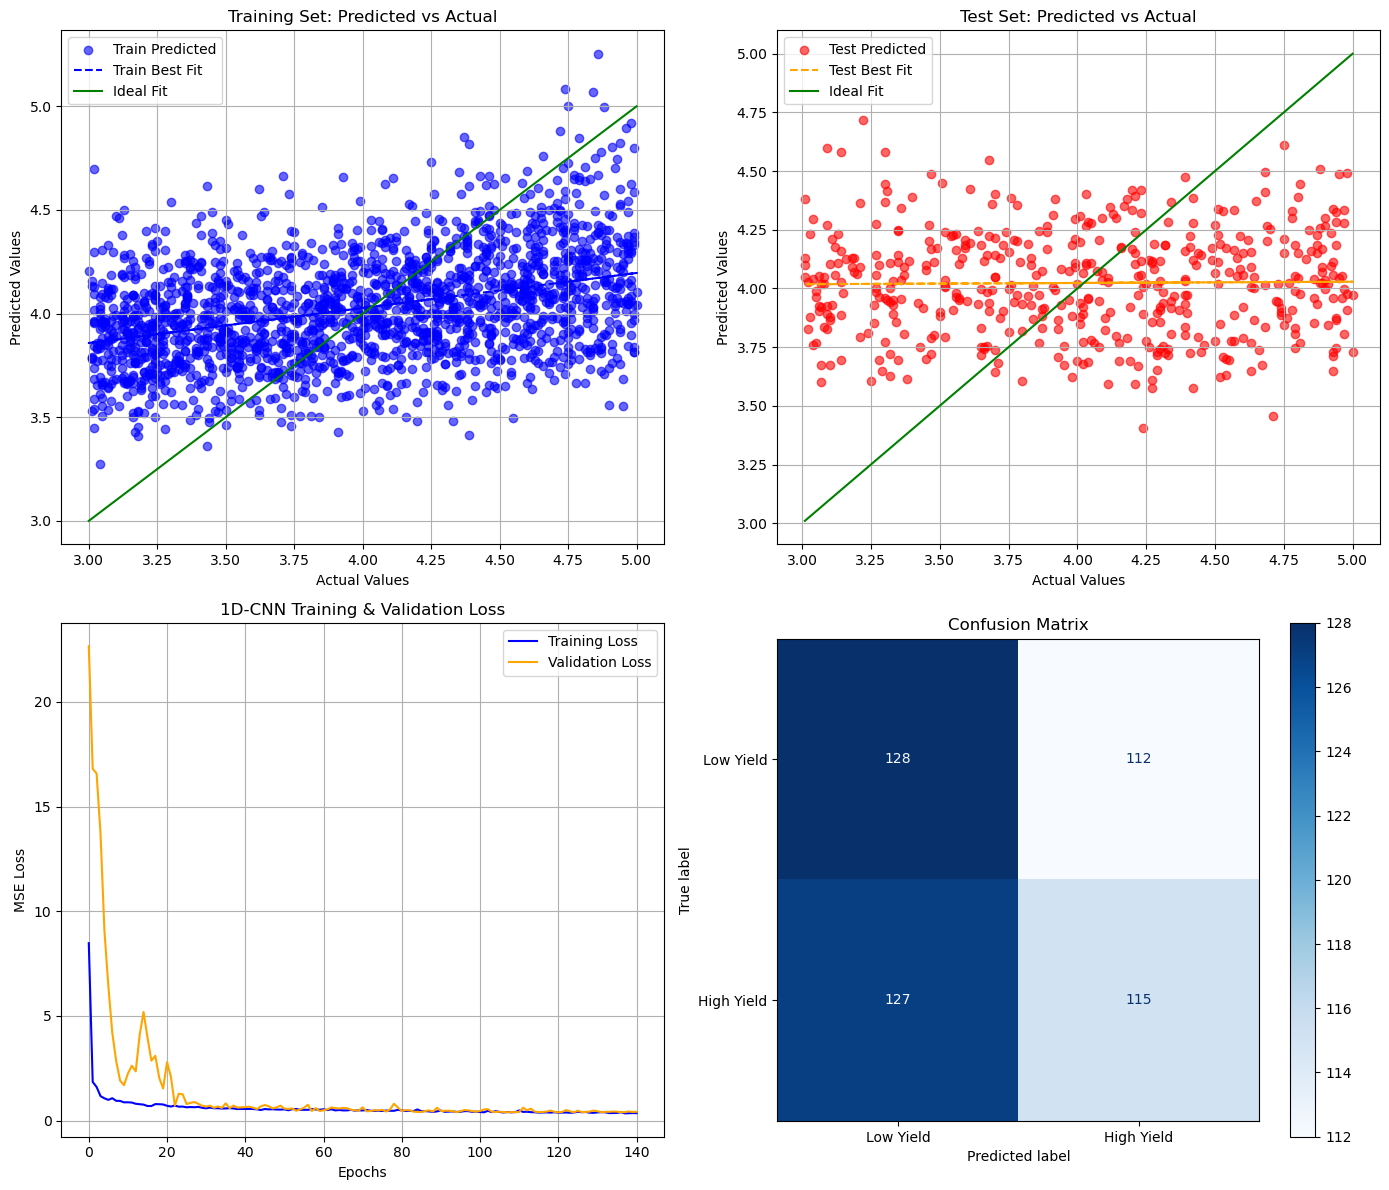

In [10]:
# CNN-1D (Convolutional Neural Network – One Dimensional)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pickle

# Load CSV files
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks.csv"
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Features and target
target_column = "Yield"
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Save scaler for reuse
with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# Reshape for 1D-CNN input
X_train_scaled = X_train_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

# Build and train 1D-CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1],1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

# Save final model
model.save("CNN1D_final_model.keras")
print("Model saved as CNN1D_final_model.keras")

# REUSE SAVED MODEL 
model_loaded = load_model("CNN1D_final_model.keras")
scaler_loaded = pickle.load(open("scaler_X.pkl", "rb"))

X_train_scaled_loaded = scaler_loaded.transform(X_train)[..., np.newaxis]
X_test_scaled_loaded = scaler_loaded.transform(X_test)[..., np.newaxis]

y_pred_train = model_loaded.predict(X_train_scaled_loaded).flatten()
y_pred_test = model_loaded.predict(X_test_scaled_loaded).flatten()

# Evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

print("\nLoaded 1D-CNN Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test RPD   : {test_rpd:.4f}")

# 2x2 Grid Plot

fig, axes = plt.subplots(2, 2, figsize=(14,12))

# 1. Train scatter
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')
z_train = np.polyfit(y_train, y_pred_train, 1)
p_train = np.poly1d(z_train)
axes[0,0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")
axes[0,0].set_title("Training Set: Predicted vs Actual")
axes[0,0].set_xlabel("Actual Values")
axes[0,0].set_ylabel("Predicted Values")
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Test scatter
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')
z_test = np.polyfit(y_test, y_pred_test, 1)
p_test = np.poly1d(z_test)
axes[0,1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")
axes[0,1].set_title("Test Set: Predicted vs Actual")
axes[0,1].set_xlabel("Actual Values")
axes[0,1].set_ylabel("Predicted Values")
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Training & Validation Loss
axes[1,0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1,0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1,0].set_title("1D-CNN Training & Validation Loss")
axes[1,0].set_xlabel("Epochs")
axes[1,0].set_ylabel("MSE Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# 4. Confusion Matrix (Regression → Classification)
y_test_class = (y_test >= np.median(y_test)).astype(int)
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)
cm = confusion_matrix(y_test_class, y_pred_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])
disp.plot(ax=axes[1,1], cmap=plt.cm.Blues, values_format="d")
axes[1,1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()


Test Section